In [1]:
import pandas as pd
from datasets import load_from_disk
from collections import Counter
import matplotlib.pyplot as plt

### Loading Dataset: Train, Val, Test ###

In [2]:
# https://stackoverflow.com/questions/2352181/how-to-use-a-dot-to-access-members-of-dictionary
class dotdict(dict):
    """dot.notation access to dictionary attributes, as dict.key_name, not as dict["key_name"] """
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


In [3]:
import yaml

# Read config.yaml file
with open("config.yaml") as infile:
    SAVED_CFG = yaml.load(infile, Loader=yaml.FullLoader)
    SAVED_CFG = dotdict(SAVED_CFG)

# arguments setting
data_args = dotdict(SAVED_CFG.data)
model_args = dotdict(SAVED_CFG.custom_model)

dataset = load_from_disk(data_args.dataset_name)
### Includes Train & Validation data ###

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
        num_rows: 3952
    })
    validation: Dataset({
        features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
        num_rows: 240
    })
})

In [5]:
dataset['train'][0]

{'title': '미국 상원',
 'context': '미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.\\n\\n미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다.\\n\\n미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05',
 'question': '대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?',
 'id': 'mrc-1-000067',
 'answers': {'answer_start'

#### Converting to Pandas Dataframe for convenient analysis

In [6]:
import pandas as pd
def pull_out_dictionary(df_input: pd.DataFrame):
    """pull out str `{}` values from the pandas dataframe and shape it as a new column"""

    df = df_input.copy()

    # assign subject_entity and object_entity column values type as dictionary
    # df["answers"] = df["answers"].apply(lambda x: eval(x))
    
    df = df.assign(
        # subject_entity
        answer_start=lambda x: x["answers"].apply(lambda x: x["answer_start"]),
        text=lambda x: x["answers"].apply(lambda x: x["text"]),
    )

    # drop subject_entity and object_entity column
    df = df.drop(["answers"], axis=1)

    return df


In [7]:
### Converting to Pandas dataframe for convenient analysis ###
train_df = pull_out_dictionary(pd.DataFrame.from_records(dataset['train']))
val_df = pull_out_dictionary(pd.DataFrame.from_records(dataset['validation']))

In [8]:
### Train DF ###
train_df.head(2)

,title,context,question,id,document_id,__index_level_0__,answer_start,text
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,18293,42,[235],[하원]
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,51638,2873,[212],[《경영의 실제》]


In [20]:
### VAL DF ###
val_df.sample(20)

,title,context,question,id,document_id,__index_level_0__,answer_start,text
38,중화민국의 동성결혼,2017년 5월 현재 동반자 등록제를 실시 중인 중화민국의 자치정부는 11 곳으로 ...,동반자 등록제를 최초로 실시한 중국의 도시는?,mrc-0-004654,46522,3036,[212],[가오슝 시]
8,노트르담 다리,예부터 노트르담 다리는 큰 다리(Grand-pont)라고 불리면서 센 강을 가로지르...,루이 14세의 왕비 마리아 테래사는 어느 나라 공주인가?,mrc-0-002875,13804,1890,[625],[스페인]
171,폰토스의 에바그리오스,에바그리오스는 《수행론》에서 영적 수행을 실천하는 수도사를 괴롭히는 유혹과 어려움에...,수행에 대해 근본적으로 의문을 제기함으로써 영적 수행자의 수행 의지를 갉아먹는 것은...,mrc-0-005154,56462,3356,[502],[아케디아]
88,소칙,"조조가 죽고, 서평의 국연이 반란을 일으켜 호강교위(護羌校尉)를 자칭하였으나, 소칙...",무위의 오랑캐들의 횡포로 길이 끊긴 사실을 소칙에게 알린 사람의 관직은?,mrc-0-005270,35771,3432,[256],[무위태수]
182,Good Boy (백지영의 노래),2012년 5월 22일 시민운동 단체 남성연대는 굿보이의 음원유통금지 가처분 신청을...,굿보이'에 대한 비판글이 올라온 곳은?,mrc-0-003566,34956,2337,[58],[남성연대 홈페이지]
86,아구스틴 쿠에바,"라틴아메리카의 자본주의를 이야기할 때, 종속이론을 빼놓고는 이야기할 수 없을 것이다...",쿠에바가 생각하는 자본주의 체제는?,mrc-0-003118,26141,2051,[1222],[그 자체가 계급 모순을 가지는 체제]
106,대우 브로엄,1991년 10월에 로얄 살롱과 슈퍼 살롱의 마이너 체인지 차종으로 출시되었다. 당...,로얄 살롱에 부착된 후면 번호판의 기존 위치는 어디인가?,mrc-1-001313,17480,857,[120],[트렁크]
157,성 바실리 대성당,사람들은 1880년대와 1890년대에 걸쳐 성당을 적절히 보수하기 위해 노력을 기울...,성당의 서쪽과 남쪽 부분에 난방이 가능해진 시기는?,mrc-0-005046,24533,3281,[885],[1913년]
236,티칼,현재 우리가 볼 수 있는 티칼의 모습은 펜실베이니아 대학교와 과테말라 정부의 협조 ...,공놀이 경기장 중 일부는 어디에 위치하고 있나?,mrc-0-002095,12190,1378,[343],['일곱 개의 신전 광장']
127,악마는 프라다를 입는다 (영화),《악마는 프라다를 입는다》(The Devil Wears Prada)는 2003년에 ...,《악마는 프라다를 입는다》은 어느 국가의 영화인가요?,mrc-0-004527,29022,2954,[84],[미국]


In [10]:
import pandas as pd
import numpy as np
import json

### TEST DF ###
with open("/opt/ml/data/wikipedia_documents.json", "r", encoding="utf-8") as reader:
    input_data = json.load(reader)
test_df = pd.DataFrame(input_data).T
test_df.head(2)

,text,corpus_source,url,domain,title,author,html,document_id
0,"이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...",위키피디아,TODO,None,나라 목록,None,None,0
1,이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...,위키피디아,TODO,None,나라 목록,None,None,1


In [11]:
print(f"Train Data Size: {len(train_df)}")
print(f"Validation Data Size: {len(val_df)}")
print(f"Test Data Size: {len(test_df)}")

Train Data Size: 3952
Validation Data Size: 240
Test Data Size: 60613


In [12]:
# check if there is only one value at lists inside of the column
train_df.answer_start.apply(lambda x: len(x)).value_counts() == len(train_df)

1    True
Name: answer_start, dtype: bool

In [13]:
train_df.text.apply(lambda x: len(x)).value_counts() == len(train_df)

1    True
Name: text, dtype: bool

In [15]:
# check if there is only one value at lists inside of the column
val_df.answer_start.apply(lambda x: len(x)).value_counts() == len(val_df)

1    True
Name: answer_start, dtype: bool

In [18]:
val_df.text.apply(lambda x: len(x)).value_counts() == len(val_df)

1    240
Name: text, dtype: int64

#### Analysis for 'answers' column

In [11]:
### Answer word count ###

In [12]:
### Extracting only the 'text' parts from answers column ###
answer_texts = [train_df.iloc[i]['answers']['text'] for i in range(len(train_df))]

In [13]:
answer_texts[:10]

[['하원'],
 ['《경영의 실제》'],
 ['백성'],
 ['중국'],
 ['4개'],
 ['드래곤'],
 ['형양태수 왕식'],
 ['이탈리아군'],
 ['큰아들 유'],
 ['왕대마을']]

In [14]:
### Checking the length of answer texts splitted with space ' ' ###
answer_text_lengths = [len(i[0].split()) for i in answer_texts]

In [15]:
answer_text_lengths[:20]

[1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 2]

In [16]:
number_of_answers = [len(i) for i in answer_texts]

In [17]:
Counter(number_of_answers)

Counter({1: 3952})

In [18]:
word_counts = Counter(answer_text_lengths)

In [19]:
word_counts

Counter({1: 2288,
         2: 1065,
         3: 349,
         5: 52,
         8: 7,
         6: 39,
         4: 120,
         7: 18,
         15: 1,
         9: 4,
         13: 1,
         20: 1,
         10: 3,
         14: 2,
         18: 1,
         16: 1})

In [20]:
counts = sorted([key for key,value in word_counts.items()])
freq = [word_counts[count] for count in counts]

In [21]:
counts

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 18, 20]

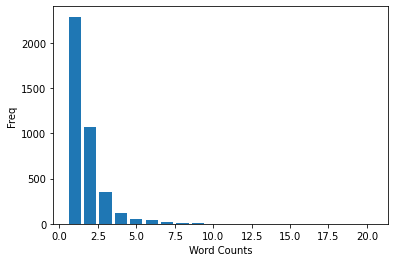

In [22]:
plt.bar(counts, freq, align = 'center')
plt.xlabel('Word Counts')
plt.ylabel('Freq')
plt.show()

## Check with klue/roberta-large tokenizer

In [8]:
import logging
import os
import sys

from typing import List, Callable, NoReturn, NewType, Any
import dataclasses
from datasets import load_metric, load_from_disk, Dataset, DatasetDict

from transformers import AutoConfig, AutoModelForQuestionAnswering, AutoTokenizer

from transformers import (
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    TrainingArguments,
    set_seed,
)

from tokenizers import Tokenizer
from tokenizers.models import WordPiece

from baseline.utils_qa import postprocess_qa_predictions, check_no_error
from baseline.trainer_qa import QuestionAnsweringTrainer
from baseline.retrieval import SparseRetrieval

import yaml

# Read config.yaml file
with open("config.yaml") as infile:
    SAVED_CFG = yaml.load(infile, Loader=yaml.FullLoader)
    SAVED_CFG = dotdict(SAVED_CFG)

# arguments setting
data_args = dotdict(SAVED_CFG.data)
model_args = dotdict(SAVED_CFG.custom_model)
model_args

{'model_name_or_path': 'klue/roberta-large',
 'save_steps': 100,
 'num_train_epochs': 3,
 'learning_rate': 5e-05,
 'batch_size': 32,
 'warmup_steps': 300,
 'weight_decay': 0.01,
 'validation': False}

In [9]:
import torch
from datasets import load_metric, load_from_disk, Dataset, DatasetDict, concatenate_datasets
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset)

datasets = load_from_disk(data_args.dataset_name)
train_dataset_from_huggingface = datasets['train']
valid_dataset_from_huggingface = datasets['validation']

In [11]:
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, Trainer, TrainingArguments

print(model_args.model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_args.model_name_or_path, model_input_names = ["input_ids", "attention_mask"])
config = AutoConfig.from_pretrained(model_args.model_name_or_path)

klue/roberta-large


In [12]:
import logging

# By default, the tokenizer will spit out a warning whenever we tokenize a 
# sample which ends up being more than 512 tokens. We don't care about that for
# now, though, and this cell will produce a lot of those warnings! So we'll 
# adjust the logging settings to suppress those warnings and keep the output
# cell cleaner.
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

# Record the length of each sequence (in terms of BERT tokens).
lengths = []

print('Tokenizing {:,} examples...'.format(len(train_dataset_from_huggingface)))

# For each example...
for (i, ex) in enumerate(train_dataset_from_huggingface):

    # Report progress.
    if ((i % 3000) == 0):
        print('  Tokenized {:,}.'.format(i))

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    input_ids = tokenizer.encode(ex['question'], 
                                 ex['context'],
                                 add_special_tokens = True,
                                 truncation=False,
                                 )

    # Record the non-truncated length.
    lengths.append(len(input_ids))

print('DONE.')

Tokenizing 3,952 examples...
  Tokenized 0.
  Tokenized 3,000.
DONE.


In [35]:
import numpy as np

print('Min length: {:,} tokens'.format(min(lengths)))
print('Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(np.median(lengths)))
print('3Q length: {:,} tokens'.format(np.percentile(lengths, 75)))

Min length: 256 tokens
Max length: 1,190 tokens
Median length: 462.0 tokens
3Q length: 611.0 tokens


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


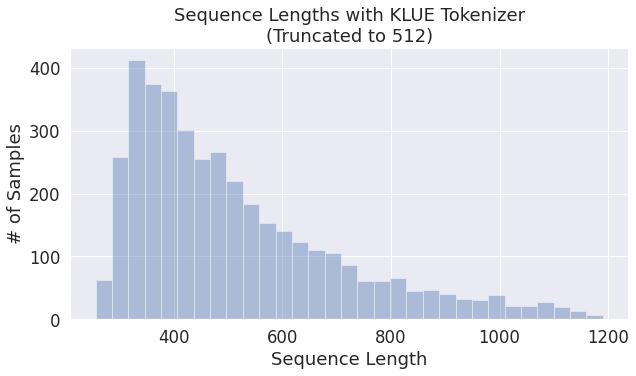

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Truncate any sequence lengths greater than 512.
# trunc_lengths = [min(l, 512) for l in lengths]

# Plot the distribution of truncated lengths.
sns.distplot(lengths, kde=False, rug=False)

# Alternatively, you might try using a log scale on the x-axis, but this is 
# tricky. See here for one approach:
# https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
#plt.xscale('log')

plt.title('Sequence Lengths with KLUE Tokenizer\n(Truncated to 512)')
plt.xlabel('Sequence Length')
plt.ylabel('# of Samples')

plt.show()

In [38]:
import numpy as np

# Cast the list to a numpy array so we can use some numpy features.
lengths = np.asarray(lengths)

# Get the total number of comments.
num_comments = len(lengths)

# Check the following lengths:
max_lens = [128, 256, 300, 384, 512, 612]

print('How many comments will be truncated?\n')

# For each choice...
for max_len in max_lens:

    # Calculate how many comments will be truncacted.
    num_over = np.sum(lengths > max_len)

    # And as a percentage.
    prcnt_over = float(num_over) / float(num_comments)

    print('max_len = {:}  -->  {:>7,} of {:>7,}  ({:>5.1%})  ' \
          'will be truncated '.format(
              max_len, num_over, num_comments, prcnt_over
          ))

How many comments will be truncated?

max_len = 128  -->    3,952 of   3,952  (100.0%)  will be truncated 
max_len = 256  -->    3,951 of   3,952  (100.0%)  will be truncated 
max_len = 300  -->    3,788 of   3,952  (95.9%)  will be truncated 
max_len = 384  -->    2,742 of   3,952  (69.4%)  will be truncated 
max_len = 512  -->    1,545 of   3,952  (39.1%)  will be truncated 
max_len = 612  -->      985 of   3,952  (24.9%)  will be truncated 
